All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
cnmr_ir/idx_3_ga_run/3_ga_details.pkl
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.


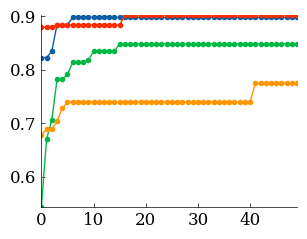

In [33]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

all_pickle = list(Path("cnmr_ir").rglob("idx_*/*.pkl"))

def plot_ga_progress(file):
    df = pd.read_pickle(file)
    max_scores = [d["max"] for d in df.gen_info]
    if len(set(max_scores)) <= 3:
        print("All generations have the same max score.")
        return
    if df.gen_info[0]["max"] < 0.6:
        print(i)
    plt.plot(max_scores, marker='o', label=file.stem)

for i in all_pickle:
    plot_ga_progress(file=  i)

Text(0, 0.5, 'Tanimoto similarity')

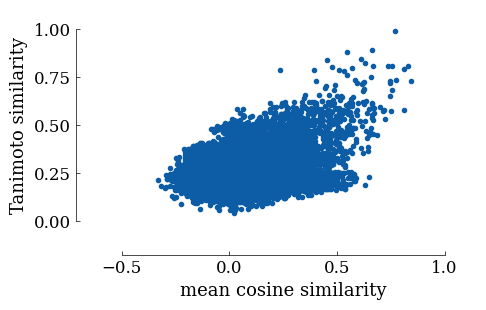

In [34]:
import matplotlib as mpl

all_paths_candidates = list(Path("cnmr_ir/analyzer_candidates_output").rglob("*.csv"))
data = pd.read_csv(f"./cnmr_ir/analyzer_candidates_output/{all_paths_candidates[6].name}")
plt.figure(figsize=(5, 3))
plt.style.use("lamalab.mpl")
mpl.rcParams['font.family'] = ['serif']
from lama_aesthetics.plotutils import range_frame
import numpy as np
range_frame(x=np.array([-0.5, 1]), y=np.array([0, 1]), ax=plt.gca(), pad=0.1)
plt.scatter(data["sum_of_all_individual_similarities"]/2, data["tanimoto"])
plt.xlabel("mean cosine similarity")
plt.ylabel("Tanimoto similarity")
